# 08 - Mixture of Gaussians Simulations

This notebook validates our PBMC unlearning findings on controlled synthetic data using the MoG module.

**Key difference from PBMC**: For MoG data, VAEs learn the component distributions rather than memorizing individual samples. We use the full unseen set (all components) as negatives for MIA, which detects training set membership.

**Note**: This was largely unsucessful. Gaussian VAE with Gaussian noise is essentially PCA. It was difficult to create synthetic data with memorizable features

Pipeline:
1. Generate MoG data and define forget set (one component)
2. Train baseline VAE (on all data including forget)
3. Train retrain VAE (gold standard, without forget)
4. Apply Fisher unlearning
5. Apply extra-gradient adversarial unlearning
6. Evaluate privacy via MIA using `train_mia_attacker_mog`

In [31]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
import copy
import json

from mog import (
    generate_mog_data, 
    create_forget_set, 
    train_vae_mog,
    train_mia_attacker_mog,
    get_latent_representations,
    compute_elbo_mog,
    compute_ari_ami
)
from vae import VAE
from utils import set_global_seed, GLOBAL_SEED, DEVICE

set_global_seed(GLOBAL_SEED)
plt.rcParams['figure.figsize'] = (12, 5)

OUTPUT_DIR = Path('../outputs/p3/mog')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Device: {DEVICE}")

Device: cpu


## Generate MoG Data and Define Splits

In [32]:
# Generate well-separated 3-component MoG in 5D
X_all, labels_all, metadata = generate_mog_data(K=3, d=5, n=6000, scenario='separated', seed=42)

# Split: 80% train, 20% held-out (unseen)
np.random.seed(42)
n_train = int(0.8 * len(X_all))
perm = np.random.permutation(len(X_all))
train_idx, unseen_idx = perm[:n_train], perm[n_train:]

X_train_full = X_all[train_idx]
labels_train_full = labels_all[train_idx]
X_unseen = X_all[unseen_idx]
labels_unseen = labels_all[unseen_idx]

# Forget set: component 0 from training data
forget_mask = create_forget_set(labels_train_full, scenario='component_removal', target_component=0, seed=42)
X_forget = X_train_full[forget_mask]
X_retain = X_train_full[~forget_mask]
labels_forget = labels_train_full[forget_mask]
labels_retain = labels_train_full[~forget_mask]

print(f"Total samples: {len(X_all)}")
print(f"Training: {len(X_train_full)}, Unseen (test): {len(X_unseen)}")
print(f"Forget (component 0): {len(X_forget)}, Retain (components 1,2): {len(X_retain)}")
print(f"Component distribution in train: {np.bincount(labels_train_full)}")
print(f"Component distribution in unseen: {np.bincount(labels_unseen)}")

Total samples: 6000
Training: 4800, Unseen (test): 1200
Forget (component 0): 1634, Retain (components 1,2): 3166
Component distribution in train: [1634 1615 1551]
Component distribution in unseen: [382 394 424]


2025-12-10 01:26:08.504018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/dbenson/.pyenv/versions/stat4243/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


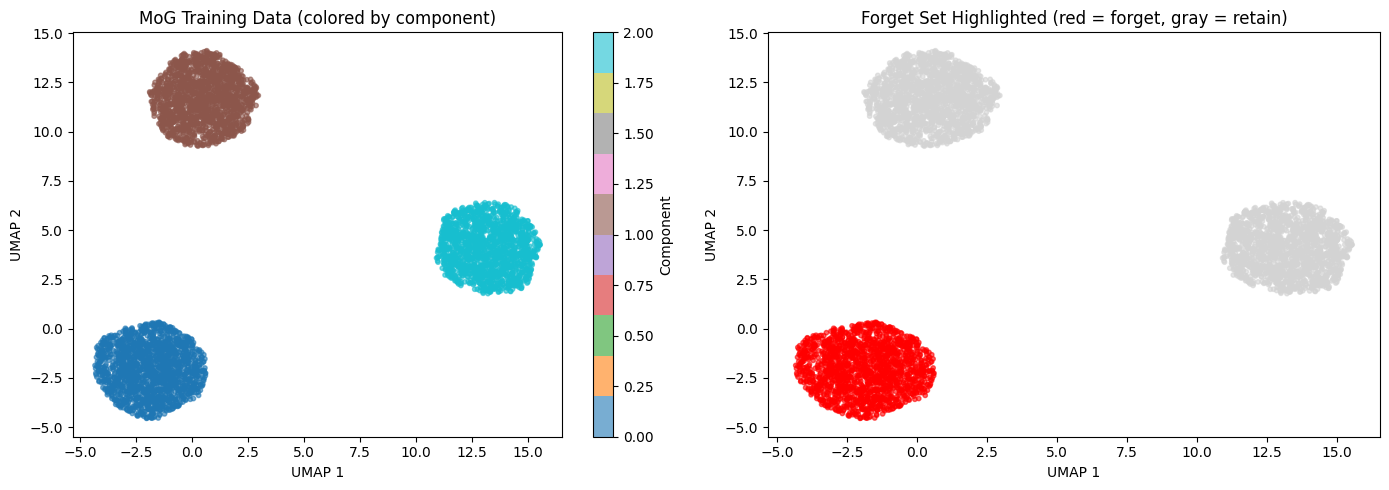

In [33]:
# UMAP visualization of synthetic MoG data
from umap import UMAP

umap_model = UMAP(n_neighbors=30, min_dist=0.3, random_state=42)
X_umap = umap_model.fit_transform(X_train_full)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Color by component
scatter1 = axes[0].scatter(X_umap[:, 0], X_umap[:, 1], c=labels_train_full, cmap='tab10', alpha=0.6, s=10)
axes[0].set_title('MoG Training Data (colored by component)')
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')
plt.colorbar(scatter1, ax=axes[0], label='Component')

# Highlight forget set (component 0)
forget_colors = np.where(forget_mask, 'red', 'lightgray')
axes[1].scatter(X_umap[:, 0], X_umap[:, 1], c=forget_colors, alpha=0.6, s=10)
axes[1].set_title('Forget Set Highlighted (red = forget, gray = retain)')
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'mog_data_umap.png', dpi=150, bbox_inches='tight')
plt.show()

## VAE Training Helpers

In [34]:
# VAE configuration - using train_vae_mog from mog.py
VAE_CONFIG = {
    'hidden_dims': [64, 32],
    'latent_dim': 2,
    'epochs': 100,
    'batch_size': 256,
    'lr': 1e-3,
    'beta': 1.0,
    'kl_warmup_epochs': 10,
    'free_bits': 0.0,
    'print_every': 25
}

print("VAE Config:", VAE_CONFIG)

VAE Config: {'hidden_dims': [64, 32], 'latent_dim': 2, 'epochs': 100, 'batch_size': 256, 'lr': 0.001, 'beta': 1.0, 'kl_warmup_epochs': 10, 'free_bits': 0.0, 'print_every': 25}


## Train Baseline and Retrain Models

In [35]:
# Train baseline VAE (on full training data including forget set)
print("Training baseline VAE on full training data...")
baseline_model = train_vae_mog(
    X_train_full,
    hidden_dims=VAE_CONFIG['hidden_dims'],
    latent_dim=VAE_CONFIG['latent_dim'],
    epochs=VAE_CONFIG['epochs'],
    batch_size=VAE_CONFIG['batch_size'],
    lr=VAE_CONFIG['lr'],
    device=DEVICE,
    beta=VAE_CONFIG['beta'],
    kl_warmup_epochs=VAE_CONFIG['kl_warmup_epochs'],
    free_bits=VAE_CONFIG['free_bits'],
    print_every=VAE_CONFIG['print_every']
)

# Train retrain VAE (gold standard - trained without forget set)
print("\nTraining retrain VAE (gold standard, without forget set)...")
retrain_model = train_vae_mog(
    X_retain,
    hidden_dims=VAE_CONFIG['hidden_dims'],
    latent_dim=VAE_CONFIG['latent_dim'],
    epochs=VAE_CONFIG['epochs'],
    batch_size=VAE_CONFIG['batch_size'],
    lr=VAE_CONFIG['lr'],
    device=DEVICE,
    beta=VAE_CONFIG['beta'],
    kl_warmup_epochs=VAE_CONFIG['kl_warmup_epochs'],
    free_bits=VAE_CONFIG['free_bits'],
    print_every=VAE_CONFIG['print_every']
)

Training baseline VAE on full training data...
Epoch 25/100: Loss=2.7031, Recon=2.0044, KL=0.6988, β=1.000
Epoch 50/100: Loss=2.6607, Recon=1.9355, KL=0.7252, β=1.000
Epoch 75/100: Loss=2.6187, Recon=1.8251, KL=0.7936, β=1.000
Epoch 100/100: Loss=2.6182, Recon=1.7849, KL=0.8333, β=1.000

Training retrain VAE (gold standard, without forget set)...
Epoch 25/100: Loss=2.1894, Recon=1.3491, KL=0.8403, β=1.000
Epoch 50/100: Loss=1.9989, Recon=1.1616, KL=0.8374, β=1.000
Epoch 75/100: Loss=1.9858, Recon=1.1159, KL=0.8698, β=1.000
Epoch 100/100: Loss=1.9278, Recon=1.0452, KL=0.8827, β=1.000


## Fisher Unlearning

Apply Fisher Information-based unlearning: scrub step (gradient ascent on forget) + finetune on retain.

In [36]:
def fisher_unlearn_mog(model, X_forget, X_retain, device, scrub_steps=50, scrub_lr=1e-3, 
                        finetune_epochs=20, finetune_lr=1e-4):
    """Fisher unlearning: scrub (gradient ascent on forget) + finetune on retain."""
    model = copy.deepcopy(model)
    optimizer = optim.Adam(model.parameters(), lr=scrub_lr)
    x_forget = torch.FloatTensor(X_forget).to(device)
    
    # Scrub phase: gradient ascent on forget set
    model.train()
    for step in range(scrub_steps):
        mu, logvar = model.encode(x_forget)
        z = model.reparameterize(mu, logvar)
        recon_mu, recon_logvar = model.decode(z)
        
        recon_loss = 0.5 * (recon_logvar + ((x_forget - recon_mu)**2) / torch.exp(recon_logvar)).sum(dim=1).mean()
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
        loss = recon_loss + kl_loss
        
        optimizer.zero_grad()
        (-loss).backward()  # Gradient ASCENT
        optimizer.step()
        
        if (step + 1) % 25 == 0:
            print(f"  Scrub step {step+1}: Loss = {loss.item():.4f}")
    
    # Finetune phase on retain set
    optimizer = optim.Adam(model.parameters(), lr=finetune_lr)
    dataset = TensorDataset(torch.FloatTensor(X_retain))
    loader = DataLoader(dataset, batch_size=256, shuffle=True)
    
    for epoch in range(finetune_epochs):
        for (x,) in loader:
            x = x.to(device)
            mu, logvar = model.encode(x)
            z = model.reparameterize(mu, logvar)
            recon_mu, recon_logvar = model.decode(z)
            
            recon_loss = 0.5 * (recon_logvar + ((x - recon_mu)**2) / torch.exp(recon_logvar)).sum(dim=1).mean()
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
            loss = recon_loss + kl_loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"  Finetune epoch {epoch+1}: Loss = {loss.item():.4f}")
    
    return model

print("Applying Fisher unlearning...")
fisher_model = fisher_unlearn_mog(baseline_model, X_forget, X_retain, DEVICE)
print("Done.")

Applying Fisher unlearning...
  Scrub step 25: Loss = 20.7953
  Scrub step 50: Loss = 456.0211
  Finetune epoch 10: Loss = 173.1829
  Finetune epoch 20: Loss = 92.2768
Done.


## Extra-gradient (Adversarial) Unlearning

Train VAE adversarially against a critic that tries to distinguish forget from unseen samples.

In [37]:
class SimpleCritic(nn.Module):
    """MLP critic for adversarial unlearning."""
    def __init__(self, input_dim=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.net(x)

def extragradient_unlearn_mog(model, X_forget, X_retain, X_unseen, device, 
                              epochs=50, lr_vae=1e-4, lr_critic=1e-5, lambda_adv=10.0):
    """Extra-gradient adversarial unlearning with TTUR."""
    model = copy.deepcopy(model)
    critic = SimpleCritic(input_dim=4).to(device)
    
    opt_vae = optim.Adam(model.parameters(), lr=lr_vae)
    opt_critic = optim.Adam(critic.parameters(), lr=lr_critic)
    
    x_forget = torch.FloatTensor(X_forget).to(device)
    x_unseen = torch.FloatTensor(X_unseen).to(device)
    
    dataset = TensorDataset(torch.FloatTensor(X_retain))
    loader = DataLoader(dataset, batch_size=256, shuffle=True)
    bce = nn.BCEWithLogitsLoss()
    
    def get_features(x):
        mu, logvar = model.encode(x)
        z = model.reparameterize(mu, logvar)
        recon_mu, recon_logvar = model.decode(z)
        recon_loss = 0.5 * (recon_logvar + ((x - recon_mu)**2) / torch.exp(recon_logvar)).sum(dim=1, keepdim=True)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1, keepdim=True)
        return torch.cat([-recon_loss, -kl_div, torch.norm(mu, dim=1, keepdim=True), torch.norm(z, dim=1, keepdim=True)], dim=1)
    
    model.train()
    critic.train()
    
    for epoch in range(epochs):
        epoch_vae_loss = 0
        epoch_adv_loss = 0
        n_batches = 0
        
        for (x_retain_batch,) in loader:
            x_retain_batch = x_retain_batch.to(device)
            
            idx_f = np.random.choice(len(x_forget), min(128, len(x_forget)), replace=False)
            idx_u = np.random.choice(len(x_unseen), min(128, len(x_unseen)), replace=False)
            
            feat_f = get_features(x_forget[idx_f])
            feat_u = get_features(x_unseen[idx_u])
            
            # Update critic
            opt_critic.zero_grad()
            pred_f = critic(feat_f.detach())
            pred_u = critic(feat_u.detach())
            critic_loss = bce(pred_f, torch.ones_like(pred_f)) + bce(pred_u, torch.zeros_like(pred_u))
            critic_loss.backward()
            opt_critic.step()
            
            # Update VAE
            opt_vae.zero_grad()
            mu, logvar = model.encode(x_retain_batch)
            z = model.reparameterize(mu, logvar)
            recon_mu, recon_logvar = model.decode(z)
            recon_loss = 0.5 * (recon_logvar + ((x_retain_batch - recon_mu)**2) / torch.exp(recon_logvar)).sum(dim=1).mean()
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
            vae_loss = recon_loss + kl_loss
            
            feat_f_new = get_features(x_forget[idx_f])
            adv_loss = bce(critic(feat_f_new), torch.zeros_like(pred_f))
            
            total_loss = vae_loss + lambda_adv * adv_loss
            total_loss.backward()
            opt_vae.step()
            
            epoch_vae_loss += vae_loss.item()
            epoch_adv_loss += adv_loss.item()
            n_batches += 1
        
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}: VAE={epoch_vae_loss/n_batches:.4f}, Adv={epoch_adv_loss/n_batches:.4f}")
    
    return model

print("Applying extra-gradient adversarial unlearning (lambda=10)...")
extragradient_model = extragradient_unlearn_mog(baseline_model, X_forget, X_retain, X_unseen, DEVICE)
print("Done.")

Applying extra-gradient adversarial unlearning (lambda=10)...
  Epoch 10: VAE=2.4602, Adv=0.5992
  Epoch 20: VAE=2.3429, Adv=0.5612
  Epoch 30: VAE=2.8633, Adv=0.2015
  Epoch 40: VAE=2.8413, Adv=0.0706
  Epoch 50: VAE=2.7713, Adv=0.0679
Done.


## Privacy Evaluation (MIA)

In [38]:
# Proper MIA evaluation with MATCHED NEGATIVES
# Compare forget (component 0 from training) vs matched unseen (component 0 from test)
# This is the only valid comparison - comparing same distribution, different splits

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Get matched negatives: component 0 from unseen set
X_unseen_matched = X_unseen[labels_unseen == 0]
print(f"Forget set (component 0, training): {len(X_forget)}")
print(f"Matched negatives (component 0, unseen): {len(X_unseen_matched)}")

def extract_mia_features(model, X):
    """Extract MIA features from model."""
    model.eval()
    with torch.no_grad():
        x = torch.FloatTensor(X).to(DEVICE)
        mu, logvar = model.encode(x)
        z = model.reparameterize(mu, logvar)
        recon_mu, recon_logvar = model.decode(z)
        
        recon_loss = 0.5 * (recon_logvar + ((x - recon_mu)**2) / torch.exp(recon_logvar)).sum(dim=1)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        elbo = -(recon_loss + kl_div)
        
        features = torch.stack([
            elbo, -recon_loss, -kl_div,
            torch.norm(mu, dim=1), torch.norm(z, dim=1)
        ], dim=1).cpu().numpy()
    return features

def evaluate_mia_matched(model, X_forget, X_unseen_matched):
    """Evaluate MIA AUC with matched negatives and train/test split."""
    feat_pos = extract_mia_features(model, X_forget)
    feat_neg = extract_mia_features(model, X_unseen_matched)
    
    X = np.concatenate([feat_pos, feat_neg])
    y = np.concatenate([np.ones(len(feat_pos)), np.zeros(len(feat_neg))])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    return roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print("\nEvaluating MIA with matched negatives (component 0 only)...\n")

auc_baseline = evaluate_mia_matched(baseline_model, X_forget, X_unseen_matched)
auc_fisher = evaluate_mia_matched(fisher_model, X_forget, X_unseen_matched)
auc_extragradient = evaluate_mia_matched(extragradient_model, X_forget, X_unseen_matched)
auc_retrain = evaluate_mia_matched(retrain_model, X_forget, X_unseen_matched)

results_df = pd.DataFrame({
    'Model': ['Baseline', 'Fisher', 'Extra-gradient', 'Retrain'],
    'AUC (F vs Matched U)': [auc_baseline, auc_fisher, auc_extragradient, auc_retrain]
})
print(results_df.to_string(index=False))

Forget set (component 0, training): 1634
Matched negatives (component 0, unseen): 382

Evaluating MIA with matched negatives (component 0 only)...

         Model  AUC (F vs Matched U)
      Baseline              0.501189
        Fisher              0.507578
Extra-gradient              0.497870
       Retrain              0.501154


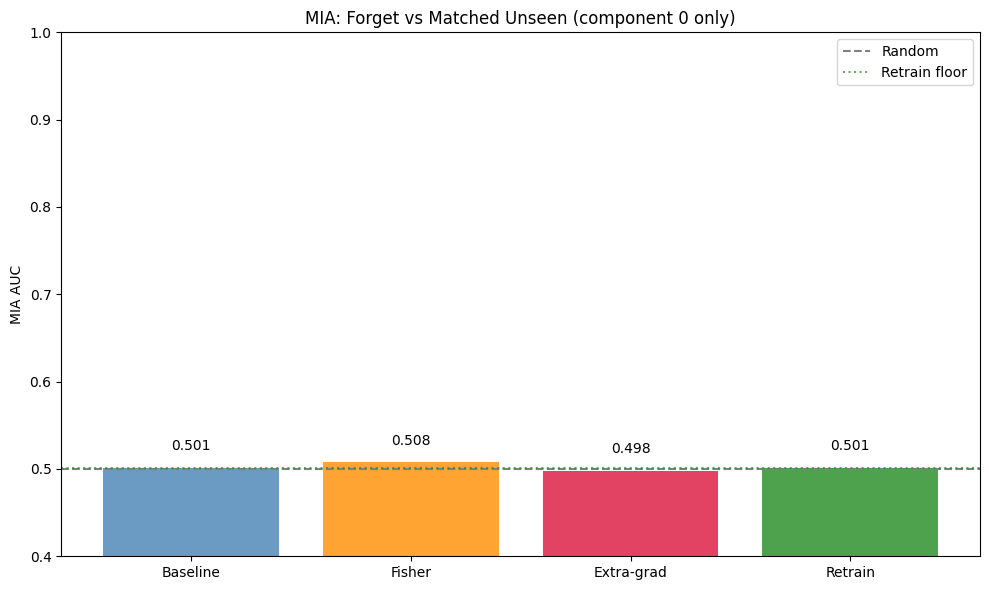

In [39]:
# Visualize results - single comparison with matched negatives
fig, ax = plt.subplots(figsize=(10, 6))

methods = ['Baseline', 'Fisher', 'Extra-grad', 'Retrain']
aucs = [auc_baseline, auc_fisher, auc_extragradient, auc_retrain]
colors = ['steelblue', 'darkorange', 'crimson', 'forestgreen']

bars = ax.bar(methods, aucs, color=colors, alpha=0.8)
ax.axhline(y=0.5, color='gray', linestyle='--', label='Random')
ax.axhline(y=auc_retrain, color='forestgreen', linestyle=':', alpha=0.7, label='Retrain floor')
ax.set_ylabel('MIA AUC')
ax.set_title('MIA: Forget vs Matched Unseen (component 0 only)')
ax.set_ylim(0.4, 1.0)
ax.legend(loc='upper right')

for bar, auc in zip(bars, aucs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{auc:.3f}', ha='center')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'mia_results.png', dpi=150, bbox_inches='tight')
plt.show()

## Latent Space Visualization

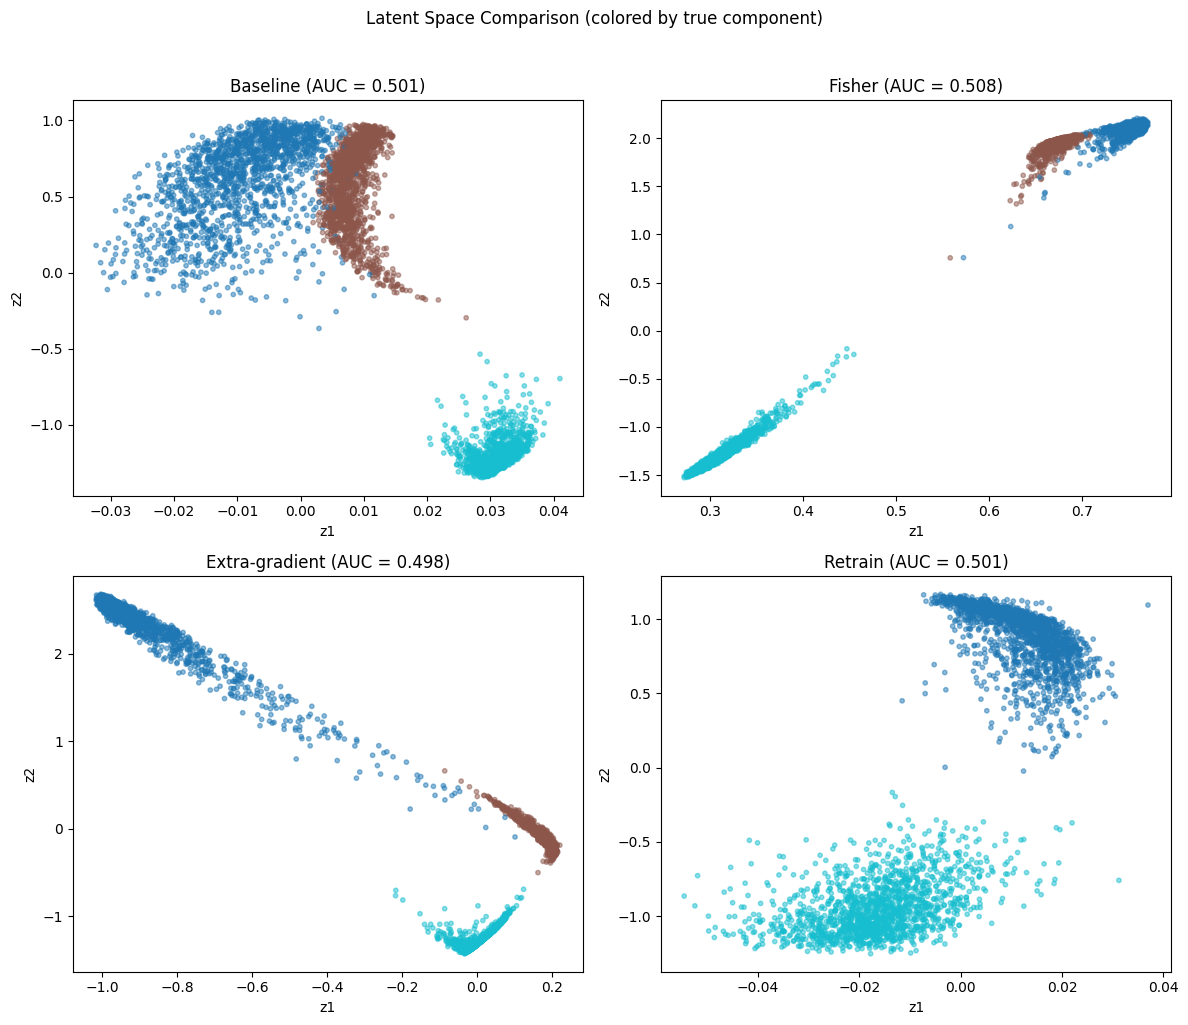

In [42]:
# Visualize latent space for all models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

models_info = [
    (baseline_model, 'Baseline', X_train_full, labels_train_full, auc_baseline),
    (fisher_model, 'Fisher', X_train_full, labels_train_full, auc_fisher),
    (extragradient_model, 'Extra-gradient', X_train_full, labels_train_full, auc_extragradient),
    (retrain_model, 'Retrain', X_retain, labels_retain, auc_retrain)
]

for ax, (model, name, X_data, labels_data, auc) in zip(axes.flatten(), models_info):
    latents = get_latent_representations(model, X_data, DEVICE)
    scatter = ax.scatter(latents[:, 0], latents[:, 1], c=labels_data, cmap='tab10', alpha=0.5, s=10)
    ax.set_title(f'{name} (AUC = {auc:.3f})')
    ax.set_xlabel('z1')
    ax.set_ylabel('z2')

plt.suptitle('Latent Space Comparison (colored by true component)', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'latent_space.png', dpi=150, bbox_inches='tight')
plt.show()

In [41]:
# Save results
results = {
    'method_id': 'mog_simulation',
    'data': {
        'K': 3, 'd': 5, 'n': 6000,
        'scenario': 'separated',
        'forget_scenario': 'component_removal',
        'forget_component': 0,
        'forget_size': int(len(X_forget)),
        'retain_size': int(len(X_retain)),
        'matched_negatives_size': int(len(X_unseen_matched))
    },
    'vae_config': VAE_CONFIG,
    'mia_auc_matched': {
        'baseline': float(auc_baseline),
        'fisher': float(auc_fisher),
        'extragradient': float(auc_extragradient),
        'retrain': float(auc_retrain)
    }
}

with open(OUTPUT_DIR / 'mog_unlearning_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results saved to {OUTPUT_DIR / 'mog_unlearning_results.json'}")
print(f"Figures saved to {OUTPUT_DIR}")

Results saved to ../outputs/p3/mog/mog_unlearning_results.json
Figures saved to ../outputs/p3/mog


## Summary

This notebook attempted to validate unlearning on controlled MoG synthetic data. However, the results show a fundamental limitation:

**All models have AUC ≈ 0.5** - the MIA cannot distinguish training from unseen samples.

**Why this happens**: A Gaussian VAE trained on Gaussian mixture data reduces to something close to PCA. The model learns the component distributions rather than memorizing individual samples. Since training and unseen samples from the same component follow identical distributions, there's no "memorization signal" for the MIA to detect.

**Implications**:
- MoG with Gaussian VAEs is not a suitable testbed for demonstrating machine unlearning
- Unlearning assumes some degree of sample-level memorization exists to be removed
- The PBMC results are more meaningful because scRNA-seq data has individual cell variation that can be memorized

**Contrast with PBMC**: In the PBMC experiments, the baseline shows clear memorization (AUC ~0.77) because individual cells have unique gene expression profiles that the VAE can overfit to. The MoG experiment confirms that unlearning is only relevant when memorization exists.